In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

Function to minimize

In [5]:
def rss(labels,predictions):
    return np.sum(np.square(labels-predictions))

Syntethic data generation. As usually happens, X is given back with shape (N,1), which is more general than the array version (it should be able to deal with multiple features as well).

In [10]:
def generate(N, noise):
    X = np.random.randn(N)

    y = np.sin(X) + noise * np.random.randn(N)

    return X.reshape(-1,1),y

### Linear regression with OLS closed formula. 
The implementation follows scikit-learn Linear Regression.

In [15]:
def lr(X,y):
    Xstd = X.std(axis = 0)
    Xmean = X.mean(axis=0)
    Ymean = y.mean(axis = 0)

    X = (X - Xmean)/Xstd
    y = y - Ymean

    coef = np.linalg.inv(X.T @ X) @ X.T @ y
    coef /= Xstd
    
    intercept = Ymean - np.dot(Xmean, coef.T)
    return intercept, coef

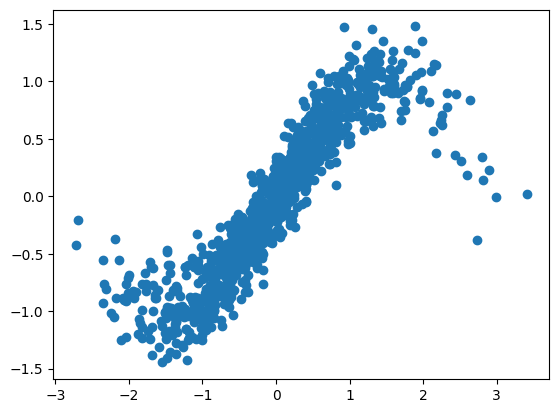

In [16]:
X,y = generate(1000,0.2)
plt.scatter(X, y)

In [17]:
weights = lr(X,y)

In [18]:
pred = weights[0] + X @ weights[1] 

In [19]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
yp = linear_regressor.predict(X)

Let's compare weights.

In [61]:
df = pd.DataFrame({"intercept" : [linear_regressor.intercept_, weights[0]], "coefficient" :   [linear_regressor.coef_, weights[1]]}, index=["ScikitLearn", "OLS"])
df

,intercept,coefficient
ScikitLearn,-0.020705,[0.6180398927821588]
OLS,-0.020705,[0.6180398927821585]


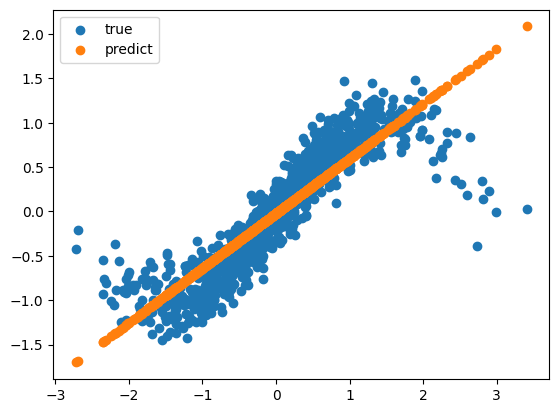

In [62]:
plt.scatter(X,y,label="true")
plt.scatter(X,pred,label="predict")
plt.legend()

In [63]:
print(f"Scikit Learn rss = {rss(labels=y,predictions=yp)}")
print(f"OLS rss = {rss(labels=y,predictions=pred)}")

Scikit Learn rss = 101.59067681336438
OLS rss = 101.5906768133644


### Gradient descent.

We'll minimize rss leveraging on rss formulation.

![image](images/gradientrss.png)

Gradient descent implementation. Notice that X is reshaped to be vector-like to leverage numpy broadcasting.

In [64]:
def gradientIntercept(X,y, w):
    return -2 * np.sum(y-(X * w[1] + w[0]))
    # g = 0
    # for i in range(X.shape[0]):
    #     g += y[i] - (w[1] * X[i] + w[0])
    # return -2 * g

def gradientCoef(X,y,w):
    return -2 * np.sum((y - (X * w[1] + w[0])) * X)
    # g = 0
    # for i in range(X.shape[0]):
    #     g += (y[i] - (w[1] * X[i] + w[0])) * X[i]
    # return -2 * g

def gd(X,y):
    weights = np.zeros(2)
    lr = 0.01
    if len(X.shape) == 2:
        X = X.reshape(-1)

    for i in range(100):
        g0 = gradientIntercept(X,y,weights)
        g1 = gradientCoef(X,y,weights)
        

        w0 = weights[0] - lr/(i+1) * g0
        w1 = weights[1] - lr/(i+1) * g1

        nw = np.array([w0,w1])
        
        if np.linalg.norm(nw-weights) < 1e-5:
            print(f"Stop at iteration {i+1}")
            break
        weights = nw
    return nw[0],nw[1]

In [65]:
wGd = gd(X,y)

Stop at iteration 22


In [66]:
pd.concat([df,pd.DataFrame({"intercept" : weights[0],"coefficient": weights[1]}, index=["GD"])])

,intercept,coefficient
ScikitLearn,-0.020705,[0.6180398927821588]
OLS,-0.020705,[0.6180398927821585]
GD,-0.020705,0.61804


In [69]:
predGD = X * wGd[1] + wGd[0]

In [73]:
print(f"Rss gradient descent = {rss(labels=y,predictions=predGD.reshape(-1))}")
print(f"Rss OLS = {rss(labels=y,predictions=pred)}")

Rss gradient descent = 101.5906768153715
Rss OLS = 101.5906768133644


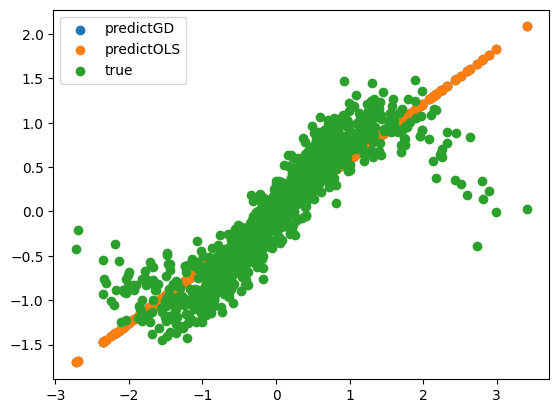

In [72]:
plt.scatter(X,predGD,label="predictGD")
plt.scatter(X,pred,label="predictOLS")
plt.scatter(X,y,label="true")
plt.legend()